In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, cm

import argparse

from theory import MeanField
from data_utils import MNISTtrainer
# from utils import compute_training_acc


def d_tanh(x):
    """Derivative of tanh."""
    return 1. / np.cosh(x)**2


def simple_plot(x, y):
    plt.plot(x, y)

    plt.xlim(1.0, 4.0)
    plt.ylim(10, 100)
    plt.xlabel('$\sigma_\omega^2$', fontsize=16)
    plt.ylabel('depth scale', fontsize=16)
    plt.show()


def plot(x, y, train_acc_contour=None):
    fontsize = 20
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=int(fontsize / 1.5))
    plt.rc('ytick', labelsize=int(fontsize / 1.5))

    # plot contour
    if train_acc_contour:
        # parse
        xgrid = train_acc_contour['xgrid']
        ygrid = train_acc_contour['ygrid']
        train_acc = train_acc_contour['train_acc']

        # plot contourf
        XGrid, YGrid = np.meshgrid(xgrid, ygrid)
        trian_acc_range = np.linspace(0., 1.0, 11, endpoint=True)

        plt.contourf(XGrid, YGrid, train_acc, trian_acc_range, cmap=cm.PuBu_r)
        plt.colorbar()

    # plot theoretical prediction with different multipliers
    plt.plot(x, y, linewidth=2, linestyle='dashed', color='#8e0000')
    plt.plot(x, y * 2, linewidth=2, linestyle='dashed', color='#c60000')
    plt.plot(x, y * 4.5, linewidth=3, linestyle='dashed', color='red')

    # add text
    plt.text(2.5, 12, r'$\xi_{c^*}$', fontsize=fontsize, color='#8e0000')
    plt.text(2.8, 22, r'2$\xi_{c^*}$', fontsize=fontsize, color='#c60000')
    plt.text(3.0, 30, r'4.5$\xi_{c^*}$', fontsize=fontsize, color='red')

    # setting
    plt.xlim(1.0, 4.0)
    plt.ylim(10, 100)
    plt.xlabel(r'$\sigma_w^2$', fontsize=fontsize)
    plt.ylabel(r'\textit{depth}', fontsize=fontsize)

    # show plot
    plt.tight_layout()
    plt.show()


def exp_depth_scale(filename=None):
    if filename:
        print('Load existing result for depth scale experiment.')
        f = np.load(filename)
        return [f['sws'], f['xi_cs']]

    print('Start depth scale experiment.')

    # Run mean field experiment
    mf = MeanField(np.tanh, d_tanh)

    # set initial condition
    qa0, qb0, c0 = 0.8, 0.8, 0.6

    # set variance of bias and weight
    sb, sws = 0.05, np.linspace(1, 4, 50)

    # set max literation and convergence threshold
    maxL, tol = 300, 1e-6

    # run mean field experiment
    xi_cs = [mf.xi_c(sw, sb, qa0, qb0, c0, maxL, tol) for sw in sws]
    # np.savez('depth_scale', sws=sws,xi_cs=xi_cs)

    return (sws, xi_cs)

def exp_trainability(args, filename=None):
    if filename:
        print('Load existing result for train accuracy.')
        f = np.load(filename)
        return dict(xgrid=f['xgrid'],
                    ygrid=f['ygrid'],
                    train_acc=f['train_acc'])

    print('Start trainability experiment.')

    # setup dataset and hyper-params
    dataset = MNISTtrainer(args.batch_size)
    params = dict(device='cpu' if args.no_cuda else 'cuda',
                  width=args.width, lr=args.lr, num_train=args.num_train,
                  sb=0.05,
     )
    if args.debug: print(params)

    # run experiment in grid coordinate.
    sws = np.linspace(1., 4., args.num_sw)
    depths = np.linspace(10, 100, args.num_depth, dtype=int)
    accs = list()
    for i, depth in enumerate(depths):
        for j, sw in enumerate(sws):
            params['depth'], params['sw'] = depth, sw
            acc = compute_training_acc(dataset, params, debug=args.debug_train_acc)
            accs.append(acc)
            if args.debug: print('({},{})->[d={},sw={}]: \t Train Acc: {:.6f}'.format(i,j,depth,sw,acc))

    acc = np.array(accs).reshape((len(depths), len(sws)))
    # np.savez('train_acc', xgrid=sws,ygrid=depths,train_acc=acc)

    return dict(xgrid=sws,ygrid=depths,train_acc=acc)

"""
if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--depth-scale-file', default=None, type=str,
                        help='file name of depth scale data')
    parser.add_argument('--train-acc-file', default=None, type=str,
                        help='file name of train accuracy data')

    # the following arguments are only for trainability experiment.
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--num-sw', default=90, type=int,
                        help='number of weight variance between [1,4]')
    parser.add_argument('--num-depth', default=91, type=int,
                        help='number of depth between [10,100]')
    parser.add_argument('--batch-size', default=256, type=int,
                        help='batch size for SGD')
    parser.add_argument('--num-train', default=200, type=int,
                        help='number of training steps')
    parser.add_argument('--width', default=300, type=int,
                        help='width of fully-connected layer')
    parser.add_argument('--lr', default=1e-3, type=float,
                        help='learning rate for SGD')
    parser.add_argument('--debug', action='store_true', default=False,
                        help='debug the main experiment')
    parser.add_argument('--debug-train-acc', action='store_true', default=False,
                        help='debug the compute_train_acc func')

    args = parser.parse_args()

    # Run experiment.
    sws, xi_cs = exp_depth_scale(args.depth_scale_file)
    # train_acc = exp_trainability(args, args.train_acc_file)

    # for simplified figure
    simple_plot(sws, xi_cs)

    # for creating the actual figure in the paper.
    # plot(sws, xi_cs, train_acc)
    """

'\nif __name__ == "__main__":\n\n    parser = argparse.ArgumentParser()\n    parser.add_argument(\'--depth-scale-file\', default=None, type=str,\n                        help=\'file name of depth scale data\')\n    parser.add_argument(\'--train-acc-file\', default=None, type=str,\n                        help=\'file name of train accuracy data\')\n\n    # the following arguments are only for trainability experiment.\n    parser.add_argument(\'--no-cuda\', action=\'store_true\', default=False,\n                        help=\'disables CUDA training\')\n    parser.add_argument(\'--num-sw\', default=90, type=int,\n                        help=\'number of weight variance between [1,4]\')\n    parser.add_argument(\'--num-depth\', default=91, type=int,\n                        help=\'number of depth between [10,100]\')\n    parser.add_argument(\'--batch-size\', default=256, type=int,\n                        help=\'batch size for SGD\')\n    parser.add_argument(\'--num-train\', default=200, t

In [9]:
depth_scale_file = "depth_scale.npz"
sws, xi_cs = exp_depth_scale(depth_scale_file)

Load existing result for depth scale experiment.


In [10]:
sws

array([1.        , 1.06122449, 1.12244898, 1.18367347, 1.24489796,
       1.30612245, 1.36734694, 1.42857143, 1.48979592, 1.55102041,
       1.6122449 , 1.67346939, 1.73469388, 1.79591837, 1.85714286,
       1.91836735, 1.97959184, 2.04081633, 2.10204082, 2.16326531,
       2.2244898 , 2.28571429, 2.34693878, 2.40816327, 2.46938776,
       2.53061224, 2.59183673, 2.65306122, 2.71428571, 2.7755102 ,
       2.83673469, 2.89795918, 2.95918367, 3.02040816, 3.08163265,
       3.14285714, 3.20408163, 3.26530612, 3.32653061, 3.3877551 ,
       3.44897959, 3.51020408, 3.57142857, 3.63265306, 3.69387755,
       3.75510204, 3.81632653, 3.87755102, 3.93877551, 4.        ])

In [1]:
def relu_derivative(z):
    return np.greater(z, 0)

def relu(z):
    return np.maximum(z, 0)

In [82]:
from tqdm import tqdm

# mf = MeanField(np.tanh, d_tanh)
mf = MeanField(relu, relu_derivative)

# set initial condition
qa0, qb0, c0 = 0.8, 0.8, 0.6

# set variance of bias and weight
# sb, sws = 0.05, np.linspace(1, 4, 50)
sb, sws = 0.05, np.linspace(1.8, 2.2, 8)

# set max literation and convergence threshold
maxL, tol = 300, 1e-6

# run mean field experiment
xi_cs = []
for sw in tqdm(sws): 
    xi_cs.append(mf.xi_c(sw, sb, qa0, qb0, c0, maxL, tol))

 38%|███▊      | 3/8 [01:22<02:28, 29.74s/it]/root/anaconda3/envs/mpenv/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 75%|███████▌  | 6/8 [05:32<02:23, 71.82s/it]/mnt/c/Users/Arnisa/Desktop/MP/reproduce/mp-tl-study/theory.py:77: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return sb + sw * quad(self._qmap_density, -np.inf, np.inf, args=(q))[0]
/mnt/c/Users/Arnisa/Desktop/MP/reproduce/mp-tl-study/theory.py:43: RuntimeWarning: invalid value encountered in sqrt
  y_x = (c * x + np.sqrt(1. - c * c) * y)  # Conditional

KeyboardInterrupt: 

In [50]:
# what is an example c star (fixed point)?
sw = 2.0
sb = 0.5
mf.c_star(sw, sb, qa0, qb0, c0, maxL=maxL, tol=tol)

(0.999870288501636,
 [0.6,
  0.8015677353139874,
  0.8760428229385807,
  0.9133049207425276,
  0.9351065259441687,
  0.949162067587336,
  0.9588462783102571,
  0.9658503091501326,
  0.9711070907867099,
  0.9751696052028205,
  0.9783844879360304,
  0.9809789875792432,
  0.9831076707809199,
  0.9848789532988972,
  0.9863708930703369,
  0.9876409665979947,
  0.988732332528039,
  0.9896779573498878,
  0.9905034070870045,
  0.991228782340547,
  0.991870074123751,
  0.9924401473128796,
  0.9929494552177486,
  0.9934065681166766,
  0.9938185709957061,
  0.9941913693555048,
  0.9945299075779737,
  0.994838369613779,
  0.9951203065040178,
  0.9953787516997059,
  0.9956163099065405,
  0.9958352287036424,
  0.9960374563762561,
  0.9962246895292168,
  0.9963984098957216,
  0.9965599192509578,
  0.996710362252699,
  0.9968507515953673,
  0.9969819845417067,
  0.9971048588935352,
  0.9972200861193419,
  0.9973283023870239,
  0.997430078079443,
  0.9975259258672293,
  0.9976163076048659,
  0.99770164

In [83]:
sws

array([1.8       , 1.85714286, 1.91428571, 1.97142857, 2.02857143,
       2.08571429, 2.14285714, 2.2       ])

In [84]:
xi_cs

[9.37275410081525,
 13.21282854150405,
 21.797155828871492,
 56.14273118330948,
 -162.4272802299052,
 -30.437620006012377]

In [70]:
def simple_plot(x, y):
    plt.plot(x, y)
    plt.xlim(1.0, 4.0)
    plt.ylim(0, 10)
    plt.xlabel('$\sigma_\omega^2$', fontsize=16)
    plt.ylabel('depth scale', fontsize=16)
    plt.show()

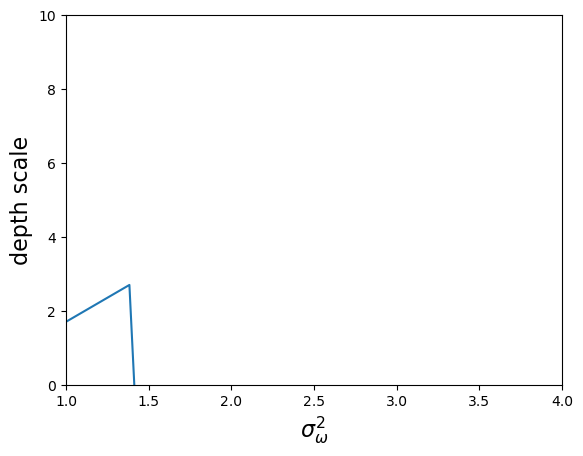

In [75]:
simple_plot(sws, xi_cs)

In [57]:
mf.sw_sb(, 1)

(1.9999999999999996, 2.303929616531697e-19)

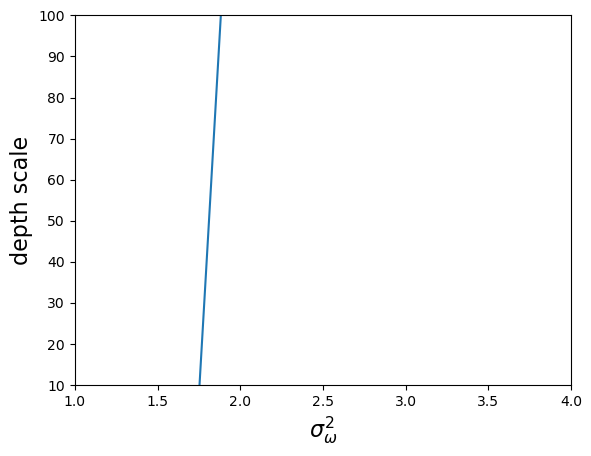

In [46]:
simple_plot(sws, xi_cs)

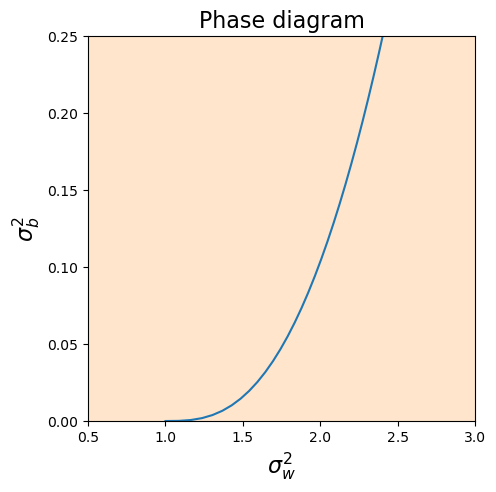

In [24]:
background = [255.0/255.0, 229/255.0, 204/255.0]
fontsize=16

mf = MeanField(np.tanh, d_tanh)
n = 50
qrange = np.linspace(1e-5, 2.25, n)

sw = [mf.sw_sb(q, 1)[0] for q in qrange]
sb = [mf.sw_sb(q, 1)[1] for q in qrange]


plt.figure(figsize=(5, 5))
plt.plot(sw, sb)
plt.xlim(0.5, 3)
plt.ylim(0, 0.25)
plt.title('Phase diagram', fontsize=fontsize)
plt.xlabel('$\sigma_w^2$', fontsize=fontsize)
plt.ylabel('$\sigma_b^2$', fontsize=fontsize)

plt.gca().set_facecolor(background)
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[1], plt.gcf().get_size_inches()[1])

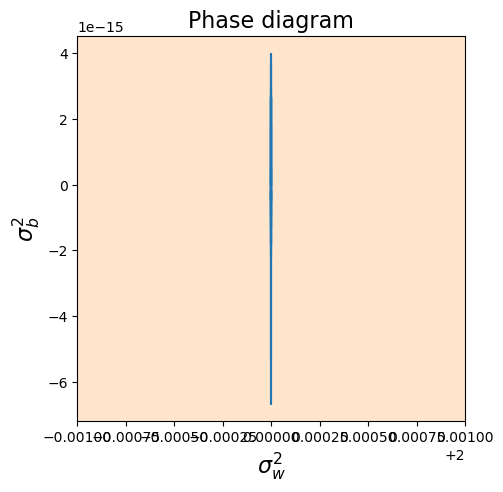

In [37]:
background = [255.0/255.0, 229/255.0, 204/255.0]
fontsize=16

mf = MeanField(relu, relu_derivative)
n = 50
qrange = np.linspace(0, 5., n)

sw = [mf.sw_sb(q, 1)[0] for q in qrange]
sb = [mf.sw_sb(q, 1)[1] for q in qrange]


plt.figure(figsize=(5, 5))
plt.plot(sw, sb)
plt.xlim(1.999, 2.001)
# plt.ylim(0, 0.25)
plt.title('Phase diagram', fontsize=fontsize)
plt.xlabel('$\sigma_w^2$', fontsize=fontsize)
plt.ylabel('$\sigma_b^2$', fontsize=fontsize)

plt.gca().set_facecolor(background)
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[1], plt.gcf().get_size_inches()[1])

In [36]:
sw

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.9999999999999996,
 2.0000000000000058,
 2.0000000000000027,
 1.9999999999999982,
 2.0000000000000004,
 2.0,
 1.9999999999999996,
 2.0000000000000004,
 1.9999999999999982,
 1.9999999999999991,
 1.9999999999999996,
 2.0000000000000004,
 2.0,
 2.0,
 2.0,
 1.9999999999999996,
 2.0,
 1.9999999999999996,
 1.9999999999999996,
 2.0,
 2.0,
 1.9999999999999996,
 2.0,
 1.9999999999999996,
 1.9999999999999996]

In [26]:
sb

[1.3332586580984754e-15,
 0.00010134032300423285,
 0.0006655671557690146,
 0.001898818749204001,
 0.003883712394599087,
 0.0066472155118615095,
 0.01018877451679201,
 0.014493658772711804,
 0.019539842907867422,
 0.025301754755265027,
 0.03175238763066174,
 0.03886451230121657,
 0.04661137342686972,
 0.054967082118692834,
 0.06390682570701167,
 0.07340696621261844,
 0.0834450707966965,
 0.09399990089938237,
 0.10505137679384524,
 0.11658052813393727,
 0.12856943721731418,
 0.1410011792318021,
 0.15385976217283504,
 0.16713006809398645,
 0.18079779668310114,
 0.19484941171884085,
 0.20927209067703567,
 0.22405367757164885,
 0.23918263899760417,
 0.25464802327001346,
 0.2704394225114368,
 0.28654693751585336,
 0.30296114520815354,
 0.319673068516688,
 0.33667414848052046,
 0.3539562184206082,
 0.3715114800134187,
 0.3893324811160017,
 0.40741209520209565,
 0.42574350227953617,
 0.4443201711694347,
 0.4631358430373502,
 0.4821845160757843,
 0.5014604312458828,
 0.5209580589940233,
 0.5406

In [88]:
import copy
def change(a):
    a = copy.deepcopy(a)
    a.append(5)
    print(a)

In [89]:
a = [1,2,3]
change(a)

[1, 2, 3, 5]


In [90]:
a

[1, 2, 3]